-----------
Initializing structure...
time for choose_chunkdivision = 9.20296e-05 s
Working in 3D dimensions.
Computational cell is 0.916667 x 0.916667 x 2.4 with resolution 60
     block, center = (0,0,-0.8)
          size (0.92,0.92,0.4)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.0025,6.0025,6.0025)
     cone, center = (0,0,-0.15)
          radius 0.35, height 0.9, axis (0, 0, 1)
          radius2 0.1
          dielectric constant epsilon diagonal = (6.0025,6.0025,6.0025)
time for set_epsilon = 6.67737 s
-----------
Meep: using complex fields.


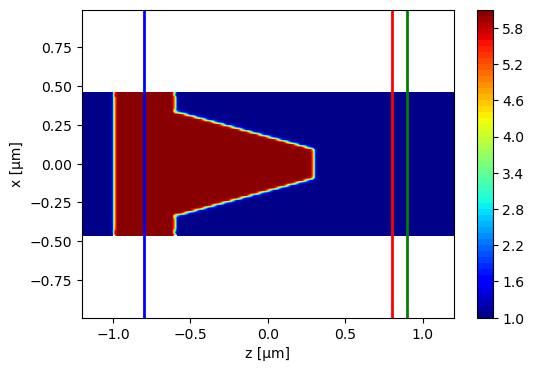

Meep progress: 1.55/200.0 = 0.8% done in 4.0s, 513.5s to go
on time step 186 (time=1.55), 0.021563 s/step
Meep progress: 3.3666666666666667/200.0 = 1.7% done in 8.0s, 468.3s to go
on time step 404 (time=3.36667), 0.0183779 s/step
Meep progress: 5.125/200.0 = 2.6% done in 12.0s, 457.3s to go
on time step 615 (time=5.125), 0.0189856 s/step
Meep progress: 6.983333333333333/200.0 = 3.5% done in 16.0s, 443.3s to go
on time step 838 (time=6.98333), 0.0179981 s/step
Meep progress: 8.783333333333333/200.0 = 4.4% done in 20.1s, 436.6s to go
on time step 1054 (time=8.78333), 0.0185923 s/step
Meep progress: 11.033333333333333/200.0 = 5.5% done in 24.1s, 412.3s to go
on time step 1324 (time=11.0333), 0.0148645 s/step
Meep progress: 12.866666666666667/200.0 = 6.4% done in 28.1s, 408.4s to go
on time step 1544 (time=12.8667), 0.018205 s/step
Meep progress: 14.666666666666666/200.0 = 7.3% done in 32.1s, 405.4s to go
on time step 1760 (time=14.6667), 0.0185282 s/step
Meep progress: 16.483333333333334/

AttributeError: 'Simulation' object has no attribute 'get_flux_dara'

In [3]:
import meep as mp
import numpy as np
import matplotlib.pyplot as plt

N = 50 # No. of wavelengths
# wavelengths = np.linspace(1,5,N) # Sweeping wavelengths in um
# Transmissions = np.zeros(N) # Array to store transmission
# wavelengths = 3
fcen = 1/3 # center frequency
df = 1/2 # pulse width

# for k in range(1):

# user parameters (unchanged) 
resolution = 60
sx, sy, sz = 0.92, 0.92 , 2.4
cell_size  = mp.Vector3(sx, sy, sz)
pml        = 0.2
cube_height= 0.4

n          = 2.45 # Refractive index of As2S3
epsr       = n**2 # Relative permittivity
wavelength = 1.55 # Simulation wavelength
# frequency  = 1 / wavelength # Simulation frequency
k_mag      = 2*np.pi / wavelength # k-vector or wave number
k_point    = mp.Vector3(k_mag*0.2, k_mag*0.2, 0) # Floquet boundary condition along x & y

# cone
base_radius = 0.7/2
top_radius  = 0.2/2
cone_height = 0.9
cone_center = mp.Vector3(0,0,-sz/2 + pml + cube_height + cone_height/2)
cone = mp.Cone(radius=base_radius, radius2=top_radius,
               height=cone_height,
               center=cone_center,
               axis=mp.Vector3(0,0,1), # Cone base axis
               material=mp.Medium(epsilon=epsr))

# cube "below" the cone     
cube_center  = mp.Vector3(0,0,-sz/2 + pml + cube_height/2)
cube = mp.Block(size=mp.Vector3(sx, sy, cube_height),
                center=cube_center,
                material=mp.Medium(epsilon=epsr))
     
# Source location
source_z    = sz/2 - pml - 0.2 # just inside top, outside PML

# Monitor locations
refl_z      = sz/2 - pml - 0.1 # Monitor to capture reflection (above source)
trans_z     = -sz/2 + pml + cube_height/2 # Monitor to capture transmission (middle of base)

# Source
'''
# CW source
sources = [mp.Source(src=mp.ContinuousSource(frequency=frequency),
                     center=mp.Vector3(0,0,source_z),
                     size=mp.Vector3(sx, sy, 0),
                     component=mp.Ez)]
'''
# Pulsed (broadband) source 
sources = [mp.Source(mp.GaussianSource(fcen,fwidth=df),
                     component = mp.Ez,
                     center = mp.Vector3(0,0,source_z),
                     size = mp.Vector3(sx,sy,0))]


# build & run
sim = mp.Simulation(cell_size       = cell_size,
                    geometry        = [cube,cone],
                    sources         = sources,
                    resolution      = resolution,
                    boundary_layers = [mp.PML(pml, direction=mp.Z)],
                    k_point         = k_point,
                    dimensions      = 3)

sim.init_sim() # Simulate

nfreq = 100 # Number of frequencies
# Monitor 1 (reflected flux)
refl_reg = mp.FluxRegion(center=mp.Vector3(0,0,refl_z),
                         size=mp.Vector3(sx, sy, 0))
refl_flux = sim.add_flux(fcen,df,nfreq,refl_reg)

# Monitor 2 (transmitted flux)
trans_reg = mp.FluxRegion(center=mp.Vector3(0,0,trans_z),
                         size=mp.Vector3(sx, sy, 0))
trans_flux = sim.add_flux(fcen,df,nfreq,trans_reg)

# visualizing structure
eps_3d = sim.get_array(center=mp.Vector3(),
                       size=cell_size,
                       component=mp.Dielectric)

# Take 2D slice at middle y index
eps_2d = eps_3d[:, eps_3d.shape[1] // 2, :]

# Plot the structure only during first iteration
# if k ==0:
plt.figure(figsize=(6,4))
x = np.linspace(-sx/2, sx/2, eps_2d.shape[0])
z = np.linspace(-sz/2, sz/2, eps_2d.shape[1])
plt.contourf(*np.meshgrid(z, x), eps_2d, 50, cmap='jet')
plt.colorbar()
plt.axis('equal')
plt.xlabel('z [µm]')
plt.ylabel('x [µm]')
plt.axvline(x=source_z, color='red', linewidth=2) # Plot source
plt.axvline(x=refl_z, color='green', linewidth=2) # Plot reflection monitor
plt.axvline(x=trans_z, color='blue', linewidth=2) # Plot transmission monitor
plt.show()

# run and fetch transmission
# sim.run(until_after_sources=mp.stop_when_fields_decayed(50,mp.Ez,mp.Vector3(0,0,-sz/2+pml+cube_height/2),1e-3))
# sim.run(until=200)
sim.run(until=200) 
# Transmissions[k] = T # Store normalized transmission
# print(f"Transmission: {T:.6f}")

In [8]:
R = sim.get_flux_data(refl_flux)
T = sim.get_flux_data(trans_flux)
flux_freqs = mp.get_flux_freqs(refl_flux)

In [18]:
R = np.array(R)
T = np.array(T)

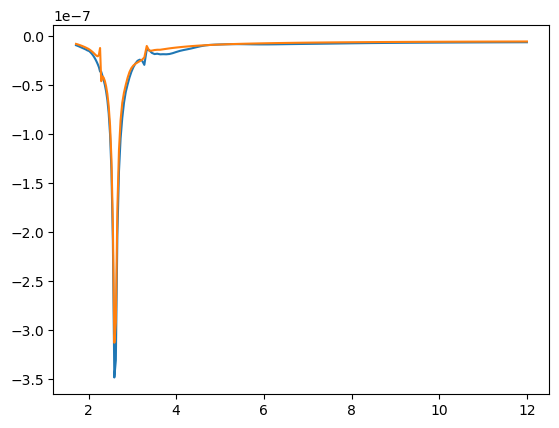

In [28]:
wl = []
Rs = []
Ts = []
for k in range(nfreq):
    wl = np.append(wl,1/flux_freqs[k])
    Rs = np.append(Rs,abs(R[0][k]))
    Ts = np.append(Ts,abs(T[0][k]))

fig,ax=plt.subplots()
ax.plot(wl,-Rs)
ax.plot(wl,-Ts)